# Modelo de deep learning baseado na memória de curto prazo (LSTM)

## Bibliotecas

In [34]:
# Estamos usando a versão 3.10.11 do python

# pip install numpy pandas scikit-learn keras pathlib os-sys

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

## Ler bases

In [35]:
# Manipular caminho para pegar o caminho onde as bases estão
base_diretório = Path(os.getcwd())
diretório_princapl = base_diretório.parent
caminho = diretório_princapl / 'Bases' / 'Bitcoin Historical Data.csv'

# Ler arquivo da base
acao = pd.read_csv(caminho)
acao['Date'] = pd.to_datetime(acao['Date'])

acao

,Date,Price,Open,High,Low,Volume,Change %
0,2017-01-01,995.4,963.4,1001.6,956.1,41150.0,3.33
1,2017-01-02,1017.0,995.4,1031.7,990.2,64950.0,2.17
2,2017-01-03,1033.3,1017.0,1035.5,1006.5,54790.0,1.60
3,2017-01-04,1135.4,1033.3,1148.5,1022.3,156270.0,9.88
4,2017-01-05,989.3,1135.4,1150.6,874.5,240010.0,-12.86
...,...,...,...,...,...,...,...
2795,2024-08-27,59450.9,62832.2,63201.4,58187.3,108530.0,-5.40
2796,2024-08-28,59016.0,59425.6,60198.4,57912.1,109470.0,-0.73
2797,2024-08-29,59373.5,59027.3,61150.6,58807.1,87190.0,0.61
2798,2024-08-30,59119.7,59371.7,59817.6,57874.7,87310.0,-0.43


In [36]:
# Diretório base onde os arquivos CSV estão localizados
base_diretório = Path(os.getcwd())
diretório_princapl = base_diretório.parent
caminho = diretório_princapl / 'Bases'

# Definir caminho dos arquivos 
arquivos = {
    'Bitcoin': caminho / 'Bitcoin Historical Data.csv',
    'Ethereum': caminho / 'Ethereum Historical Data.csv',
    'BNB': caminho / 'BNB Historical Data.csv',
    'Solana': caminho / 'Solana Historical Data.csv',
}

# Ler o arquivo ano.txt e pegar o ano
with open(diretório_princapl/'data'/'ano.txt', 'r') as file:
    ano = int(file.read().strip())

# Função para tratar os dados de cada criptomoeda
def tratar_dados_cripto(caminho_csv):
    # Ler o arquivo CSV
    acao = pd.read_csv(caminho_csv)
    acao['Date'] = pd.to_datetime(acao['Date'])

    return acao

# Aplicar a função para cada criptomoeda e armazenar o resultado em um DataFrame
df_bitcoin = tratar_dados_cripto(arquivos['Bitcoin'])
df_ethereum = tratar_dados_cripto(arquivos['Ethereum'])
df_bnb = tratar_dados_cripto(arquivos['BNB'])
df_solana = tratar_dados_cripto(arquivos['Solana'])

## Aplicando modelo de ML

In [37]:
# Separar um df no qual vai conter apenas os dado para treinamento
# Que é com base no ano escolhido pelo jogador
df_treinamento = acao[acao['Date'].dt.year < ano]

# Apenas cotação dos dados de treinamento 
cotacao_treinamento = df_treinamento['Price'].to_numpy().reshape(-1, 1)

# Cotação dos dados da base toda
cotacao = acao['Price'].to_numpy().reshape(-1, 1)

# Armazenar tamanho dos dados de treinamento
tamanho_dados_treinamento = int(len(cotacao_treinamento) * 1)

print(f"Tamanho dos dados de treinamento: {tamanho_dados_treinamento}\n")

print(cotacao)

Tamanho dos dados de treinamento: 2191

[[  995.4]
 [ 1017. ]
 [ 1033.3]
 ...
 [59373.5]
 [59119.7]
 [58978.6]]


In [38]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 
escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                
dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00314642],
       [0.00347005],
       [0.00371428],
       ...,
       [0.87782298],
       [0.8740203 ],
       [0.87190621]])

In [39]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.00314642, 0.00347005, 0.00371428, 0.00524403, 0.00305502,
       0.00151028, 0.00155074, 0.00173053, 0.00171405, 0.00178297,
       0.        , 0.00037008, 0.00059033, 0.00051242, 0.00053639,
       0.00062779, 0.00171255, 0.00129752, 0.00164513, 0.00161067,
       0.00201371, 0.00199873, 0.00203918, 0.00162415, 0.00163314,
       0.00195078, 0.00198674, 0.00199423, 0.0019343 , 0.00202719,
       0.00269843, 0.00295164, 0.00327527, 0.00341012, 0.0036918 ,
       0.00345657, 0.00358542, 0.0039585 , 0.0040469 , 0.0029007 ,
       0.00317938, 0.0033397 , 0.0031629 , 0.00314642, 0.0033397 ,
       0.0033382 , 0.0036933 , 0.0039555 , 0.00399895, 0.00394801,
       0.00437802, 0.00499831, 0.00502079, 0.00579091, 0.00585983,
       0.0054493 , 0.00578642, 0.00604412, 0.00605162, 0.00655205])]
[np.float64(0.007043488032363187)]
[array([0.00314642, 0.00347005, 0.00371428, 0.00524403, 0.00305502,
       0.00151028, 0.00155074, 0.00173053, 0.00171405, 0.00178297,
       0.        , 0.00

In [40]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[0.00314642 0.00347005 0.00371428 ... 0.00604412 0.00605162 0.00655205]
 [0.00347005 0.00371428 0.00524403 ... 0.00605162 0.00655205 0.00704349]
 [0.00371428 0.00524403 0.00305502 ... 0.00655205 0.00704349 0.00746001]
 ...
 [0.29727535 0.29532756 0.29513578 ... 0.24171555 0.23853916 0.23614339]
 [0.29532756 0.29513578 0.29020489 ... 0.23853916 0.23614339 0.23749485]
 [0.29513578 0.29020489 0.29098401 ... 0.23614339 0.23749485 0.23705735]]
[[[0.00314642]
  [0.00347005]
  [0.00371428]
  ...
  [0.00604412]
  [0.00605162]
  [0.00655205]]

 [[0.00347005]
  [0.00371428]
  [0.00524403]
  ...
  [0.00605162]
  [0.00655205]
  [0.00704349]]

 [[0.00371428]
  [0.00524403]
  [0.00305502]
  ...
  [0.00655205]
  [0.00704349]
  [0.00746001]]

 ...

 [[0.29727535]
  [0.29532756]
  [0.29513578]
  ...
  [0.24171555]
  [0.23853916]
  [0.23614339]]

 [[0.29532756]
  [0.29513578]
  [0.29020489]
  ...
  [0.23853916]
  [0.23614339]
  [0.23749485]]

 [[0.29513578]
  [0.29020489]
  [0.29098401]
  ...
  [0.2361

In [41]:
#construindo o modelo

modelo = Sequential()

# Primeira camada LSTM
modelo.add(LSTM(100, return_sequences=True, input_shape=(treinamento_x.shape[1], 1)))

# Segunda camada LSTM
modelo.add(LSTM(50, return_sequences=False))

# Camada totalmente conectada com os neuronios
modelo.add(Dense(25))

# Camada final de saída
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\Arq. Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [42]:
#copilando o modelo
modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [43]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=10, epochs=20)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0102
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 9.6245e-04
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 9.3121e-04
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 5.2535e-04
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 5.3707e-04
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 5.3688e-04
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 4.1120e-04
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.9384e-04
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3.5435e-04
Epoch 10/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.2114e-04
Epoch 11/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 3.7371e-04
Epoch 12/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.6484e-04
Epoch 13/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.0009e-04
Epoch 14/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 3

In [44]:
# Vriar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [45]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [46]:
len(teste_x)

609

In [47]:
#pegando predições do modelo
predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


array([[16160.714],
       [16196.203],
       [16248.611],
       [16266.368],
       [16390.848],
       [16420.84 ],
       [16509.166],
       [16535.354],
       [16660.887],
       [16747.68 ],
       [16951.898],
       [17368.63 ],
       [18142.188],
       [19158.812],
       [20220.178],
       [20484.65 ],
       [20759.816],
       [20807.078],
       [20481.424],
       [20679.54 ],
       [21922.348],
       [22380.1  ],
       [22440.8  ],
       [22604.223],
       [22443.969],
       [22713.385],
       [22771.793],
       [22832.559],
       [22818.748],
       [23361.125],
       [22831.344],
       [22892.037],
       [23373.48 ],
       [23290.727],
       [23263.871],
       [23179.768],
       [22869.66 ],
       [22655.97 ],
       [22968.338],
       [22851.492],
       [21945.268],
       [21567.033],
       [21638.39 ],
       [21617.078],
       [21598.87 ],
       [21904.883],
       [23582.018],
       [23474.723],
       [24187.898],
       [24430.438],


In [48]:
# Criando o grafico do modelo
treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_previsao = pd.DataFrame({"Date": acao['Date'].iloc[tamanho_dados_treinamento:],
                        "Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


In [49]:
treinamento

,Date,Price,Open,High,Low,Volume,Change %
0,2017-01-01,995.4,963.4,1001.6,956.1,41150.0,3.33
1,2017-01-02,1017.0,995.4,1031.7,990.2,64950.0,2.17
2,2017-01-03,1033.3,1017.0,1035.5,1006.5,54790.0,1.60
3,2017-01-04,1135.4,1033.3,1148.5,1022.3,156270.0,9.88
4,2017-01-05,989.3,1135.4,1150.6,874.5,240010.0,-12.86
...,...,...,...,...,...,...,...
2186,2022-12-27,16706.1,16918.2,16964.0,16610.1,192180.0,-1.25
2187,2022-12-28,16546.2,16705.9,16781.1,16474.2,217960.0,-0.96
2188,2022-12-29,16636.4,16546.2,16659.1,16496.6,181470.0,0.55
2189,2022-12-30,16607.2,16636.4,16644.4,16360.0,192760.0,-0.18


In [50]:
df_previsao

,Date,Price,predicoes
2191,2023-01-01,16618.4,16160.713867
2192,2023-01-02,16674.3,16196.203125
2193,2023-01-03,16674.2,16248.611328
2194,2023-01-04,16852.1,16266.368164
2195,2023-01-05,16829.8,16390.847656
...,...,...,...
2795,2024-08-27,59450.9,63451.179688
2796,2024-08-28,59016.0,59978.714844
2797,2024-08-29,59373.5,60011.058594
2798,2024-08-30,59119.7,60370.023438


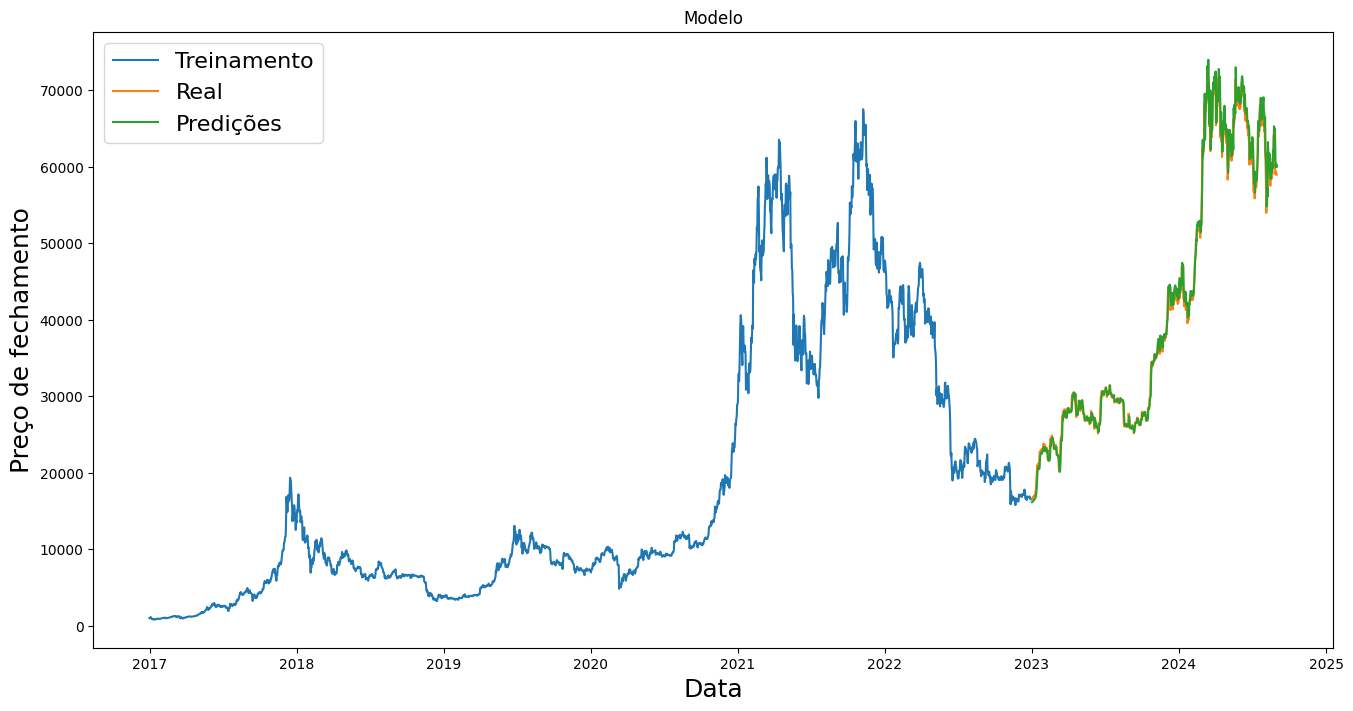

In [51]:
# Setar a data como index dos df (df_previsao e treinamento)
df_previsao.set_index('Date', inplace=True)
treinamento.set_index('Date', inplace=True)

plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento[['Price']])
plt.plot(df_previsao[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [52]:
df_previsao.sort_index()

df_previsao

,Price,predicoes
Date,,
2023-01-01,16618.4,16160.713867
2023-01-02,16674.3,16196.203125
2023-01-03,16674.2,16248.611328
2023-01-04,16852.1,16266.368164
2023-01-05,16829.8,16390.847656
...,...,...
2024-08-27,59450.9,63451.179688
2024-08-28,59016.0,59978.714844
2024-08-29,59373.5,60011.058594


In [53]:
df_previsao_semanal = df_previsao
df_previsao_semanal['Semana'] = ((df_previsao_semanal.index - df_previsao_semanal.index.min()).days // 7) + 1
df_previsao_semanal.head(30)

,Price,predicoes,Semana
Date,,,
2023-01-01,16618.4,16160.713867,1
2023-01-02,16674.3,16196.203125,1
2023-01-03,16674.2,16248.611328,1
2023-01-04,16852.1,16266.368164,1
2023-01-05,16829.8,16390.847656,1
2023-01-06,16950.9,16420.839844,1
2023-01-07,16943.6,16509.166016,1
2023-01-08,17119.0,16535.353516,2
2023-01-09,17180.1,16660.886719,2


In [54]:
df_previsao_semanal = df_previsao_semanal.reset_index() 
df_previsao_semanal

,Date,Price,predicoes,Semana
0,2023-01-01,16618.4,16160.713867,1
1,2023-01-02,16674.3,16196.203125,1
2,2023-01-03,16674.2,16248.611328,1
3,2023-01-04,16852.1,16266.368164,1
4,2023-01-05,16829.8,16390.847656,1
...,...,...,...,...
604,2024-08-27,59450.9,63451.179688,87
605,2024-08-28,59016.0,59978.714844,87
606,2024-08-29,59373.5,60011.058594,87
607,2024-08-30,59119.7,60370.023438,87


# Metricas para calcular nosso modelo de ML

### Mean Absolute Error (MAE) e Mean Absolute Percentage Error (MAPE)

In [55]:
# A média das diferenças absolutas entre as previsões e os valores reais. Penaliza todos os erros da mesma forma

mae = mean_absolute_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 888.46


In [56]:
# Calcular o MAPE
mape = mean_absolute_percentage_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} = {100*mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.0203 = 2.03%


### Root Mean Squared Error (RMSE)

In [57]:
# A raiz quadrada da média dos erros ao quadrado. Dá mais peso a grandes erros

rmse = mean_squared_error(df_previsao['Price'], df_previsao['predicoes'], squared=False)
mean_price = df_previsao['Price'].mean()

print(f"RMSE: {rmse}")
print(f"RMSE percentual: {(rmse / mean_price)} = {(rmse / mean_price)*100:.3}%")

RMSE: 1356.1463949116105
RMSE percentual: 0.032789600487393156 = 3.28%


c:\Users\Arq. Andrea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Directional Accuracy (Semanal)

In [58]:
df_previsao_semanal.reset_index() 
# Agrupar por semana e calcular o preço médio semanal para real e previsões
df_teste_semana = df_previsao_semanal.groupby('Semana').agg({
    'Price': 'first',       # Preço real médio por semana
    'predicoes': 'first',   # Previsão média por semana
    'Date': 'first'        # Pega a primeira data da semana 
})

# Adicionar colunas de mês e ano com base na coluna 'Data'
df_teste_semana['Mes'] = df_teste_semana['Date'].dt.month
df_teste_semana['Ano'] = df_teste_semana['Date'].dt.year

# Calcular a variação percentual semanal para Price e Predicoes
df_teste_semana['Variação Real (%)'] = df_teste_semana['Price'].pct_change() * 100
df_teste_semana['Variação Prevista (%)'] = df_teste_semana['predicoes'].pct_change() * 100


# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df_teste_semana = df_teste_semana.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df_teste_semana['direcao_correta'] = np.where(
    (df_teste_semana['Variação Real (%)'] > 0) & (df_teste_semana['Variação Prevista (%)'] > 0) |
    (df_teste_semana['Variação Real (%)'] < 0) & (df_teste_semana['Variação Prevista (%)'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df_teste_semana['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy (Semanal): {directional_accuracy * 100:.2f}%")

df_teste_semana

Directional Accuracy (Semanal): 87.21%


,Price,predicoes,Date,Mes,Ano,Variação Real (%),Variação Prevista (%),direcao_correta
Semana,,,,,,,,
2,17119.0,16535.353516,2023-01-08,1,2023,3.012324,2.318215,1
3,20879.8,20220.177734,2023-01-15,1,2023,21.968573,22.284519,1
4,22707.8,22380.099609,2023-01-22,1,2023,8.754873,10.682011,1
5,23753.1,22818.748047,2023-01-29,1,2023,4.603264,1.959991,1
6,22936.0,23179.767578,2023-02-05,2,2023,-3.439972,1.582122,0
...,...,...,...,...,...,...,...,...
83,68256.3,68495.460938,2024-07-28,7,2024,0.143195,0.971532,1
84,58141.8,61758.285156,2024-08-04,8,2024,-14.818412,-9.835947,1
85,58713.3,61848.246094,2024-08-11,8,2024,0.982942,0.145662,1


In [59]:
# df_teste_semana.to_csv("previsão semanal - Bitcoin.csv")